In [1]:
import os
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from sentence_transformers import SentenceTransformer, models, InputExample, losses, evaluation
from sentence_transformers.util import SiameseDistanceMetric
import numpy as np
import random
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

CONSTANTS = {
    "VOC_NAMES": ["Alpha", "Beta", "Delta", "Gamma", "Omicron"],
    "LOSS_NAME": "ContrastiveLoss",
    "NEG_SET": "other", # "other" or "delta"
    "POOLING_MODE": "max",
    "CONCAT": None, # "C" for concat-only, "CD" for concat+diff, or "CDM" for concat+diff+mult
    "NUM_LABELS": None,
    "CONF_THRESHOLD": None,
    "BATCH_SIZE": 32,
    "EPOCHS": 10,
    "LR": 1e-4,
    "RELU": 0.2,
    "DROPOUT": 0.2,
    "MARGIN": 2.0
}

In [2]:
#word_embedding_model = models.Transformer(model_name_or_path="Rostlab/prot_bert", max_seq_length=1280)

encoder = models.Transformer(model_name_or_path="./mlm_checkpoints/CoV-RoBERTa_2048",
                                          max_seq_length=1280,
                                          tokenizer_name_or_path="tok/")

dim = encoder.get_word_embedding_dimension() # 768

pooler = models.Pooling(dim, pooling_mode = CONSTANTS["POOLING_MODE"])

modules = [encoder, pooler]

if CONSTANTS["RELU"] > 0:
    dense = models.Dense(in_features=dim, out_features=int(dim*CONSTANTS["RELU"]), activation_function=nn.ReLU())
    modules.append(dense)

if CONSTANTS["DROPOUT"] > 0:
    dropout = models.Dropout(CONSTANTS["DROPOUT"])
    modules.append(dropout)

model = SentenceTransformer(modules=modules)

# # Freeze initial transformer layers
# for param in model[0].auto_model.embeddings.parameters():
#     param.requires_grad = False
# for param in model[0].auto_model.encoder.layer[:6].parameters():
#     param.requires_grad = False

print(model)

Some weights of the model checkpoint at ./mlm_checkpoints/CoV-RoBERTa_2048 were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at ./mlm_checkpoints/CoV-RoBERTa_2048 and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and

SentenceTransformer(
  (0): Transformer({'max_seq_length': 1280, 'do_lower_case': False}) with Transformer model: RobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': True, 'pooling_mode_global_max': False, 'pooling_mode_global_avg': False, 'pooling_mode_attention': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False})
  (2): Dense({'in_features': 768, 'out_features': 153, 'bias': True, 'activation_function': 'torch.nn.modules.activation.ReLU'})
  (3): Dropout(
    (dropout_layer): Dropout(p=0.2, inplace=False)
  )
)


# Generate Pairs for Training

In [3]:
TASK = "OMICRON_VS_ALL" # "OMICRON_VS_ALL" or "ALL_VS_ALL"

VOC_NAMES = ["Alpha", "Beta", "Delta", "Gamma", "Omicron"]
sequences = []
for voc_name in VOC_NAMES:
    sequences.append(pd.read_csv(f"data/unique_{voc_name}_2k.csv")["sequence"].tolist())

alpha_sequences = sequences[0].copy()
beta_sequences = sequences[1].copy()
delta_sequences = sequences[2].copy()
gamma_sequences = sequences[3].copy()
omicron_sequences = sequences[4].copy()
examples = []

if TASK == "OMICRON_VS_ALL":

    if CONSTANTS["NEG_SET"] == "other":
        others = [alpha_sequences, beta_sequences, delta_sequences, gamma_sequences]
        for i, anc in enumerate(omicron_sequences):
            # get 4 random omicron sequences
            positives = random.sample(omicron_sequences, 4)
            for p, pos in enumerate(positives):
                neg = others[p][i]
                examples.append(InputExample(texts=[anc, pos], label=1))
                examples.append(InputExample(texts=[anc, neg], label=0))
    elif CONSTANTS["NEG_SET"] == "delta":
        for i, anc in enumerate(omicron_sequences):
            # get 4 random omicron sequences
            positives = random.sample(omicron_sequences, 4)
            # get 4 random delta sequences
            negatives = random.sample(delta_sequences, 4)
            for pos, neg in zip(positives, negatives):
                examples.append(InputExample(texts=[anc, pos], label=1))
                examples.append(InputExample(texts=[anc, neg], label=0))

if TASK == "ALL_VS_ALL":
    r = 1
    done = False
    while not done:
        #print("round", r)
        for a_p_list_id in range(len(sequences)):
            n_list_ids = list(range(len(sequences))).copy()
            n_list_ids.remove(a_p_list_id)
            anchor_positive_list = sequences[a_p_list_id]
            anchor_positives = random.sample(anchor_positive_list, 5)
            anchor = anchor_positives[0]
            positives = anchor_positives[1:]
            anchor_positive_list.remove(anchor)
            for positive in positives:
                examples.append(InputExample(texts=[anchor, positive], label=1))
                anchor_positive_list.remove(positive)
            for n_list_id in n_list_ids:
                negative_list = sequences[n_list_id]
                negative = random.choice(negative_list)
                negative_list.remove(negative)
                examples.append(InputExample(texts=[anchor, negative], label=0))
            if len(sequences[0]) < 5 or len(sequences[1]) < 5 or len(sequences[2]) < 5 or len(sequences[3]) < 5 or len(sequences[4]) < 5:
                done = True
                break
        r += 1

print("Training set length:", len(examples))
# split examples list into train, validation and test sets
random.shuffle(examples)
train_size = int(len(examples) * 0.8)
val_size = int(len(examples) * 0.1)
train_examples = examples[:train_size]
val_examples = examples[train_size:train_size + val_size]
test_examples = examples[train_size + val_size:]

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=CONSTANTS["BATCH_SIZE"])
# val_dataloader = DataLoader(val_examples, shuffle=False, batch_size=CONSTANTS["BATCH_SIZE"])
# test_dataloader = DataLoader(test_examples, shuffle=False, batch_size=CONSTANTS["BATCH_SIZE"])

Training set length: 16000


# Generate Pairs for Zero-shot Test

In [4]:
o = pd.read_csv("data/unique_Omicron_2k.csv")["sequence"].tolist()
e = pd.read_csv("data/unique_Eris_2k.csv")["sequence"].tolist()[:2000]
n = pd.read_csv("data/unique_New_2k.csv")["sequence"].tolist()[:2000]

zero_test_examples = []

for i in range(len(omicron_sequences)):
        anc = o[i]
        pos = n[i]
        neg = e[i]
        zero_test_examples.append(InputExample(texts=[anc, pos], label=1))
        zero_test_examples.append(InputExample(texts=[anc, neg], label=0))

print("Zero-shot test set length: ", len(zero_test_examples))

Zero-shot test set length:  4000


# Define Loss

In [5]:
if CONSTANTS["LOSS_NAME"] == "ContrastiveLoss":
    train_loss = losses.ContrastiveLoss(model=model,
                                        distance_metric=SiameseDistanceMetric.EUCLIDEAN,
                                        margin = CONSTANTS["MARGIN"])
elif CONSTANTS["LOSS_NAME"] == "OnlineContrastiveLoss":
    train_loss = losses.OnlineContrastiveLoss(model=model,
                                              distance_metric=SiameseDistanceMetric.EUCLIDEAN,
                                              margin = CONSTANTS["MARGIN"])

# Construct Evaluators

In [6]:
evaluator = evaluation.BinaryClassificationEvaluator(
    sentences1=[val_example.texts[0] for val_example in val_examples],
    sentences2=[val_example.texts[1] for val_example in val_examples],
    labels=[val_example.label for val_example in val_examples],
    distance_metric=SiameseDistanceMetric.EUCLIDEAN,
    batch_size=CONSTANTS["BATCH_SIZE"],
    margin = CONSTANTS["MARGIN"],
    show_progress_bar=False,
    write_csv=True,
    name='Eval')

test_evaluator = evaluation.BinaryClassificationEvaluator(
    sentences1=[test_example.texts[0] for test_example in test_examples],
    sentences2=[test_example.texts[1] for test_example in test_examples],
    labels=[test_example.label for test_example in test_examples],
    batch_size=CONSTANTS['BATCH_SIZE'],
    margin=CONSTANTS['MARGIN'],
    show_progress_bar=False,
    name="Test")

zero_test_evaluator = evaluation.BinaryClassificationEvaluator(
    sentences1=[zero_test_example.texts[0] for zero_test_example in zero_test_examples],
    sentences2=[zero_test_example.texts[1] for zero_test_example in zero_test_examples],
    labels=[zero_test_example.label for zero_test_example in zero_test_examples],
    batch_size=CONSTANTS['BATCH_SIZE'],
    margin=CONSTANTS['MARGIN'],
    show_progress_bar=False,
    name="Zero")

# Prepare Folders

In [7]:
import os
import shutil

# Create output directory if needed
output_dir = f"./outputs/{CONSTANTS['LOSS_NAME']}_omicron_vs_{CONSTANTS['NEG_SET']}_" \
                f"P{CONSTANTS['POOLING_MODE']}_" \
                f"R{CONSTANTS['RELU']}_" \
                f"D{CONSTANTS['DROPOUT']}_" \
                f"E{CONSTANTS['EPOCHS']}_" \
                f"LR_{CONSTANTS['LR']}_" \
                f"B{CONSTANTS['BATCH_SIZE']}_" \
                f"M{CONSTANTS['MARGIN']}"

if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
    print(f"Removed directory: {output_dir}")

checkpoint_dir = f"{output_dir}/checkpoints"
stats_dir = f"{output_dir}/stats"

for d in [checkpoint_dir, stats_dir]:
    if not os.path.exists(d):
        os.makedirs(d)
        print(f"Created directory: {d}")

Removed directory: ./outputs/ContrastiveLoss_omicron_vs_other_Pmax_R0.2_D0.2_E10_LR_0.0001_B32_M2.0
Created directory: ./outputs/ContrastiveLoss_omicron_vs_other_Pmax_R0.2_D0.2_E10_LR_0.0001_B32_M2.0/checkpoints
Created directory: ./outputs/ContrastiveLoss_omicron_vs_other_Pmax_R0.2_D0.2_E10_LR_0.0001_B32_M2.0/stats


# Run Training & Test

In [8]:
# print CONSTANTS
for k, v in CONSTANTS.items():
    print(f"{k}: {v}")

model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          tester=test_evaluator,
          #zero_shot_tester=zero_test_evaluator,
          epochs=CONSTANTS['EPOCHS'],
          optimizer_class=torch.optim.AdamW,
          optimizer_params= {'lr': CONSTANTS['LR']}, # 1e-3 for CoV-RoBERTa, 1e-6 for ProtBERT
          weight_decay=0.1, # 0.1 for CoV-RoBERTa, 0.01 for ProtBERT
          # evaluation_steps=64,
          output_path=output_dir,
          save_best_model=True,
          #checkpoint_path=checkpoint_dir,
          #checkpoint_save_steps=len(train_dataloader),
          #checkpoint_save_total_limit=1000000,
          show_progress_bar=True,
          loss_name=CONSTANTS['LOSS_NAME'])

VOC_NAMES: ['Alpha', 'Beta', 'Delta', 'Gamma', 'Omicron']
LOSS_NAME: ContrastiveLoss
NEG_SET: other
POOLING_MODE: max
CONCAT: None
NUM_LABELS: None
CONF_THRESHOLD: None
BATCH_SIZE: 32
EPOCHS: 10
LR: 0.0001
RELU: 0.2
DROPOUT: 0.2
MARGIN: 2.0


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 0 ---
Train Loss = 0.4469   Train Accuracy = 0.6875
Eval Loss  = 0.4429   Eval Accuracy  = 0.6700    (using best distance threshold   = 0.7917)
Eval Loss  = 0.4429   Eval Accuracy  = 0.6606    (using median distance threshold = 0.7594)
Test Loss  = 0.4371   Test Accuracy  = 0.6719    (using best distance threshold   = 0.7997)
Test Loss  = 0.4371   Test Accuracy  = 0.6637    (using median distance threshold = 0.7611)


Iteration:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 1 ---
Train Loss = 0.1576   Train Accuracy = 0.9688
Eval Loss  = 0.1484   Eval Accuracy  = 0.9225    (using best distance threshold   = 0.5596)
Eval Loss  = 0.1484   Eval Accuracy  = 0.9194    (using median distance threshold = 0.4469)
Test Loss  = 0.1407   Test Accuracy  = 0.9281    (using best distance threshold   = 0.5183)
Test Loss  = 0.1407   Test Accuracy  = 0.9250    (using median distance threshold = 0.4624)


Iteration:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 2 ---
Train Loss = 0.0261   Train Accuracy = 1.0000
Eval Loss  = 0.0429   Eval Accuracy  = 0.9800    (using best distance threshold   = 0.4057)
Eval Loss  = 0.0429   Eval Accuracy  = 0.9781    (using median distance threshold = 0.3067)
Test Loss  = 0.0374   Test Accuracy  = 0.9838    (using best distance threshold   = 0.4412)
Test Loss  = 0.0374   Test Accuracy  = 0.9838    (using median distance threshold = 0.5318)


Iteration:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 3 ---
Train Loss = 0.0000   Train Accuracy = 1.0000
Eval Loss  = 0.0259   Eval Accuracy  = 0.9938    (using best distance threshold   = 0.1493)
Eval Loss  = 0.0259   Eval Accuracy  = 0.9919    (using median distance threshold = 0.0964)
Test Loss  = 0.0217   Test Accuracy  = 0.9956    (using best distance threshold   = 0.1855)
Test Loss  = 0.0217   Test Accuracy  = 0.9862    (using median distance threshold = 0.8282)


Iteration:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 4 ---
Train Loss = 0.0000   Train Accuracy = 1.0000
Eval Loss  = 0.0337   Eval Accuracy  = 0.9881    (using best distance threshold   = 0.0560)
Eval Loss  = 0.0337   Eval Accuracy  = 0.9825    (using median distance threshold = 0.0358)
Test Loss  = 0.0276   Test Accuracy  = 0.9912    (using best distance threshold   = 0.1144)
Test Loss  = 0.0276   Test Accuracy  = 0.9862    (using median distance threshold = 0.5941)


Iteration:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 5 ---
Train Loss = 0.0000   Train Accuracy = 1.0000
Eval Loss  = 0.0250   Eval Accuracy  = 0.9894    (using best distance threshold   = 0.0974)
Eval Loss  = 0.0250   Eval Accuracy  = 0.9844    (using median distance threshold = 0.0687)
Test Loss  = 0.0216   Test Accuracy  = 0.9925    (using best distance threshold   = 0.1421)
Test Loss  = 0.0216   Test Accuracy  = 0.9862    (using median distance threshold = 1.1931)


Iteration:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 6 ---
Train Loss = 0.0000   Train Accuracy = 1.0000
Eval Loss  = 0.0175   Eval Accuracy  = 0.9925    (using best distance threshold   = 0.0730)
Eval Loss  = 0.0175   Eval Accuracy  = 0.9894    (using median distance threshold = 0.0095)
Test Loss  = 0.0208   Test Accuracy  = 0.9925    (using best distance threshold   = 0.0945)
Test Loss  = 0.0208   Test Accuracy  = 0.9862    (using median distance threshold = 1.6156)


Iteration:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 7 ---
Train Loss = 0.0000   Train Accuracy = 1.0000
Eval Loss  = 0.0125   Eval Accuracy  = 0.9969    (using best distance threshold   = 0.0027)
Eval Loss  = 0.0125   Eval Accuracy  = 0.9956    (using median distance threshold = 0.1467)
Test Loss  = 0.0091   Test Accuracy  = 0.9969    (using best distance threshold   = 0.0345)
Test Loss  = 0.0091   Test Accuracy  = 0.9862    (using median distance threshold = 4.4481)


Iteration:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 8 ---
Train Loss = 0.0583   Train Accuracy = 1.0000
Eval Loss  = 0.0295   Eval Accuracy  = 0.9906    (using best distance threshold   = 0.0370)
Eval Loss  = 0.0295   Eval Accuracy  = 0.5044    (using median distance threshold = 0.0000)
Test Loss  = 0.0252   Test Accuracy  = 0.9912    (using best distance threshold   = 0.0244)
Test Loss  = 0.0252   Test Accuracy  = 0.9862    (using median distance threshold = 0.7749)


Iteration:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 9 ---
Train Loss = 0.0010   Train Accuracy = 1.0000
Eval Loss  = 0.0140   Eval Accuracy  = 0.9944    (using best distance threshold   = 2.5662)
Eval Loss  = 0.0140   Eval Accuracy  = 0.9931    (using median distance threshold = 1.9146)
Test Loss  = 0.0091   Test Accuracy  = 0.9969    (using best distance threshold   = 0.6357)
Test Loss  = 0.0091   Test Accuracy  = 0.9862    (using median distance threshold = 5.2127)


# Display Stats

In [9]:
# read loss values from csv:
f_train_stats = os.path.join(stats_dir, 'Train.csv')
f_eval_stats = os.path.join(stats_dir, 'Eval.csv')
f_test_stats = os.path.join(stats_dir, 'Test.csv')
#f_zero_stats = os.path.join(stats_dir, 'Zero.csv')

train_stats = pd.read_csv(f_train_stats)
eval_stats = pd.read_csv(f_eval_stats)
test_stats = pd.read_csv(f_test_stats)
#zero_stats = pd.read_csv(f_zero_stats)

best_test_acc = test_stats["accuracy"].max()
#best_zero_acc = zero_stats["accuracy"].max()

# create a dataframe with CONSTANTS and best accuracies
df = pd.DataFrame()
for k, v in CONSTANTS.items():
    if k not in ["VOC_NAMES"]:
        df[k] = [v] # if v is not None else ["N/A"]

df["MAX_TEST_ACC"] = best_test_acc
#df["MAX_ZERO_ACC"] = best_zero_acc

display(df)

# save the dataframe to a csv file under stats_dir
df.to_csv(os.path.join(stats_dir, "summary.csv"), index=False)

# append row to global_stats.csv
if not os.path.exists("global_stats.csv") or os.path.getsize("global_stats.csv") == 0:
    df.to_csv("global_stats.csv", index=False)
else:
    global_stats = pd.read_csv("global_stats.csv")
    global_stats = pd.concat([global_stats, df], ignore_index=True)
    global_stats.to_csv("global_stats.csv", index=False)

,LOSS_NAME,NEG_SET,POOLING_MODE,CONCAT,NUM_LABELS,CONF_THRESHOLD,BATCH_SIZE,EPOCHS,LR,RELU,DROPOUT,MARGIN,MAX_TEST_ACC
0,ContrastiveLoss,other,max,None,None,None,32,10,0.0001,0.2,0.2,2.0,0.9969


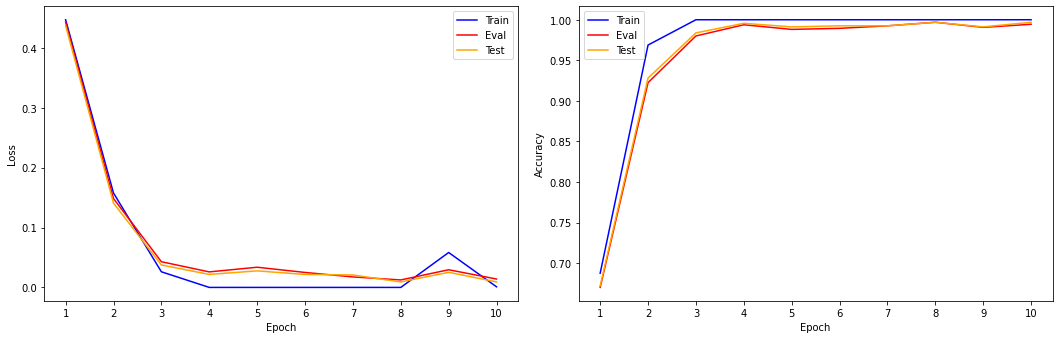

In [10]:
# Plot the training and validation loss and accuracy
import matplotlib.pyplot as plt

# plot loss and accuracy figures side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(train_stats["epoch"]+1, train_stats["loss"], label="Train", color="blue")
axs[0].plot(eval_stats["epoch"]+1, eval_stats["loss"], label="Eval", color="red")
axs[0].plot(test_stats["epoch"]+1, test_stats["loss"], label="Test", color="orange")
#axs[0].plot(zero_stats["epoch"], zero_stats["loss"], label="Zero-shot")

axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].set_xticks(train_stats["epoch"]+1)  # Set x-ticks for each epoch

axs[1].plot(train_stats["epoch"]+1, train_stats["accuracy"], label="Train", color="blue")
axs[1].plot(eval_stats["epoch"]+1, eval_stats["accuracy"], label="Eval", color="red")
axs[1].plot(test_stats["epoch"]+1, test_stats["accuracy"], label="Test", color="orange")
#axs[1].plot(zero_stats["epoch"], zero_stats["accuracy"], label="Zero-shot")

axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].set_xticks(train_stats["epoch"]+1)  # Set x-ticks for each epoch


font_size = 16
plt.rc('font', size=font_size)
plt.rc('axes', titlesize=font_size)
plt.rc('axes', labelsize=font_size)
plt.rc('xtick', labelsize=font_size-4)
plt.rc('ytick', labelsize=font_size-4)
plt.rc('legend', fontsize=font_size)
plt.rc('figure', titlesize=font_size)
plt.tight_layout()
#save as pdf
plt.savefig(os.path.join(stats_dir, "plot.pdf"))
plt.show()